# How to build a multi-agent network

!!! info "Prerequisites"
    This guide assumes familiarity with the following:
  
    - [Command](../../concepts/low_level/#command)
    - [Multi-agent systems](../../concepts/multi_agent)


In this how-to guide we will build a simple case of a [multi-agent network](../../concepts/multi_agent#network) architecture. We will create a team of agents that all run at the same time and share state. At each step, each agent will inspect the state and decide whether to halt or continue executing on the next step. If it continues, it will update the shared state. 

To do so, the agent nodes will return `Command` object that allows you to [combine both control flow and state updates](../command):

```python
def agent_one(state: State) -> Command[Literal["agent_one"]]:
    # the condition for halting/continuation can be anything, e.g. LLM tool call / structured output, etc.
    ...
    if not should_halt:
        return Command(goto="agent_one", update={"my_state_key": "my_state_value"})
```

## Setup

First, let's install the required packages

In [1]:
%%capture --no-stderr
%pip install -U langgraph

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Define graph

Our agents will be simple node functions (`agent_one|two|three`). At each step of the graph execution, each node function will inspect the `total` value in the state and decide whether it should halt or continue. If it decides to continue, it will increment the `total` value in the state and loop back to itself to run at the next step. 

Now, let's define our agent nodes and graph! 

In [2]:
from typing_extensions import Annotated, TypedDict, Literal

from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START
from langgraph.types import Command

import operator


class State(TypedDict):
    # note that we're defining a reducer (operator.add) here.
    # This will allow all agents to write their updates to `total` concurrently.
    total: Annotated[int, operator.add]


def agent_one(state: State, config: RunnableConfig) -> Command[Literal["agent_one"]]:
    # the condition for halting/continuation can be anything, e.g. LLM tool call / structured output, etc.
    should_halt = state["total"] >= 5
    if not should_halt:
        print(
            f'Running agent 1, step {config["metadata"]["langgraph_step"]}. Total={state["total"]}'
        )
        # increment total by 1 and loop back to agent 1
        return Command(goto="agent_one", update={"total": 1})


def agent_two(state: State, config: RunnableConfig) -> Command[Literal["agent_two"]]:
    should_halt = state["total"] >= 10
    if not should_halt:
        print(
            f'Running agent 2, step {config["metadata"]["langgraph_step"]}. Total={state["total"]}'
        )
        # increment total by 2 and loop back to agent 2
        return Command(goto="agent_two", update={"total": 2})


def agent_three(
    state: State, config: RunnableConfig
) -> Command[Literal["agent_three"]]:
    should_halt = state["total"] >= 15
    if not should_halt:
        print(
            f'Running agent 3, step {config["metadata"]["langgraph_step"]}. Total={state["total"]}'
        )
        # increment total by 3 and loop back to agent 3
        return Command(goto="agent_three", update={"total": 3})


builder = StateGraph(State)
# add agent nodes
builder.add_node(agent_one)
builder.add_node(agent_two)
builder.add_node(agent_three)

# add edges from start to each agent to run agents in parallel
builder.add_edge(START, "agent_one")
builder.add_edge(START, "agent_two")
builder.add_edge(START, "agent_three")
graph = builder.compile()

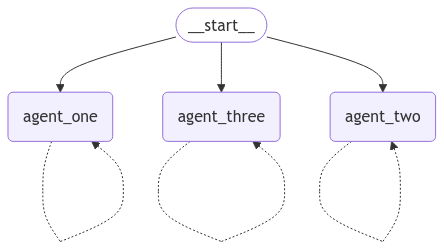

In [3]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

This is the behavior that we'll expect to see:

* __step 1__: `0 + (1 + 2 + 3) = 6`. Halt agent 1 (total >= 5)
* __step 2__: `6 + (2 + 3) = 11`. Halt agent 2 (total >= 10)
* __step 3__: `11 + 3 = 14`. Continue agent 3 (total < 15)
* __step 4__: `14 + 3 = 17`. Halt agent 3 (total >= 15)

Let's now run it!

In [4]:
input_ = {"total": 0}
res = graph.invoke(input_)
res

Running agent 1, step 1. Total=0Running agent 2, step 1. Total=0

Running agent 3, step 1. Total=0
Running agent 2, step 2. Total=6
Running agent 3, step 2. Total=6
Running agent 3, step 3. Total=11
Running agent 3, step 4. Total=14


{'total': 17}

We can verify that we ran agent 1 only once, agent 2 twice and agent 3 four times, until all agents halted. The final value of `total` is 17, as expected.